In [257]:
import sys
import sql
import pandas as pd
from functools import reduce
from tabulate import tabulate
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
norepo = 'no repository listed'
manualcheckup = 'manual checkup needed'
notgit = 'not git'

In [258]:
q= 'select * from advisory'
df = pd.DataFrame(sql.execute(q))
len(df)

6956

In [259]:
q= ''' select * from advisory where type = 'Malicious Package' '''
df = pd.DataFrame(sql.execute(q))
len(df)

589

In [260]:
q = '''select *
from advisory a
join package p on a.package_id = p.id
where type != 'Malicious Package'
and ecosystem = 'cocoapods' '''
df = pd.DataFrame(sql.execute(q))
len(df), df['id'].nunique(), df['p.id'].nunique()

(358, 358, 37)

In [261]:
q= '''select distinct advisory_id, p.id as package_id, version
from fixing_releases fr
join advisory a on fr.advisory_id = a.id
join package p on a.package_id = p.id
where ecosystem != 'cocoapods'
and type != 'Malicious Package'
and version != %s;'''
df = pd.DataFrame(sql.execute(q, (manualcheckup,)))
len(df), df['advisory_id'].nunique()

(7083, 4776)

In [262]:
q= '''select distinct advisory_id
from advisory a
join fixing_releases fr on a.id = fr.advisory_id
join package p on a.package_id = p.id
and ecosystem != 'cocoapods'
and version = 'manual checkup needed'
and advisory_id not in
(select distinct advisory_id
from advisory a
join fixing_releases fr on a.id = fr.advisory_id
join package p on a.package_id = p.id
and ecosystem != 'cocoapods'
and version != 'manual checkup needed')'''
df = pd.DataFrame(sql.execute(q))
df['advisory_id'].nunique()

102

In [263]:
q = '''select *
from advisory a
join package p on a.package_id = p.id
where type != 'Malicious Package'
and ecosystem != 'cocoapods'
and a.id not in
(select advisory_id from fixing_releases)'''
df = pd.DataFrame(sql.execute(q))
len(df), df['id'].nunique()

(1131, 1131)

In [264]:
q= '''select distinct advisory_id, p.id as package_id, version
from fixing_releases fr
join advisory a on fr.advisory_id = a.id
join package p on a.package_id = p.id
where ecosystem != 'cocoapods'
and type != 'Malicious Package'
and version != %s
and repository_url = %s'''
df = pd.DataFrame(sql.execute(q, (manualcheckup, norepo)))
len(df), df['package_id'].nunique(), df['advisory_id'].nunique()

(518, 300, 399)

In [265]:
q='''select  package_id, version, count(distinct advisory_id) as c
from advisory a
join package p on a.package_id = p.id
join fixing_releases fr on a.id = fr.advisory_id
where type != 'Malicious Package'
and version != 'manual checkup needed'
and ecosystem != 'cocoapods'
and repository_url != 'no repository listed'
group by package_id, version;'''
df = pd.DataFrame(sql.execute(q))
morethanone= df[df['c']>1]
df['c'].median(), len(df), len(morethanone)

(1.0, 4812, 738)

In [266]:
q='''select t1.ecosystem as ecosystem, advisories, advisory_with_CVEs, packages, fixing_releases
from
(select ecosystem, count(distinct a.id) as advisories, count(distinct p.id) as packages, count(distinct package_id, version) as fixing_releases
from advisory a
join package p on a.package_id = p.id
join fixing_releases fr on a.id = fr.advisory_id
where type != 'Malicious Package'
and version != 'manual checkup needed'
and ecosystem != 'cocoapods'
and repository_url != 'no repository listed'
group by ecosystem) as t1
join
(select ecosystem, count(distinct a.id) as advisory_with_CVEs
from advisoryCVE aC
join advisory a on aC.advisory_id = a.id
join fixing_releases fr on a.id = fr.advisory_id
join package p on a.package_id = p.id
where type != 'Malicious Package'
and version != 'manual checkup needed'
and ecosystem != 'cocoapods'
and repository_url != 'no repository listed'
group by ecosystem) as t2
on t1.ecosystem = t2.ecosystem
order by ecosystem asc;'''
df = pd.DataFrame(sql.execute(q))

In [267]:
df

,ecosystem,advisories,advisory_with_CVEs,packages,fixing_releases
0,Composer,855,599,228,976
1,Go,235,190,183,293
2,Maven,1374,1132,694,1607
3,npm,792,474,540,858
4,NuGet,333,277,92,233
5,pip,567,404,269,534
6,RubyGems,221,168,121,311


In [268]:
q = '''select ecosystem, ac.cwe as cwe
from advisory a
join package p on a.package_id = p.id
join fixing_releases fr on a.id = fr.advisory_id
join advisoryCWE aC on a.id = aC.advisory_id
where type != 'Malicious Package'
and version != 'manual checkup needed'
and ecosystem != 'cocoapods'
and repository_url != 'no repository listed';'''
cwe = pd.DataFrame(sql.execute(q))
total_cwes = cwe['cwe'].nunique()
cwe = cwe.groupby('ecosystem')[['cwe']].nunique()
cwe


,cwe
ecosystem,
Composer,68
Go,50
Maven,112
NuGet,34
RubyGems,47
npm,82
pip,84


In [269]:
df=reduce(lambda x,y : pd.merge(x,y,on='ecosystem'),[df, cwe])
df.reset_index()
df

,ecosystem,advisories,advisory_with_CVEs,packages,fixing_releases,cwe
0,Composer,855,599,228,976,68
1,Go,235,190,183,293,50
2,Maven,1374,1132,694,1607,112
3,npm,792,474,540,858,82
4,NuGet,333,277,92,233,34
5,pip,567,404,269,534,84
6,RubyGems,221,168,121,311,47


In [283]:
q= '''select count(*) from
(select a.id, count(distinct fr.version)
from advisory a
join package p on a.package_id = p.id
join fixing_releases fr on a.id = fr.advisory_id
join advisoryCWE aC on a.id = aC.advisory_id
where type != 'Malicious Package'
and version != 'manual checkup needed'
and ecosystem != 'cocoapods'
and repository_url != 'no repository listed'
group by a.id
having count(distinct fr.version) > 1) as sub;'''
df = pd.DataFrame(sql.execute(q))
df

,count(*)
0,1231


In [270]:
df.loc[len(df)]=['Total',df['advisories'].sum(),df['advisory_with_CVEs'].sum(),df['packages'].sum(), df['fixing_releases'].sum(), total_cwes] 
table = df

In [271]:
q = '''select distinct a.id, p.ecosystem, a.severity
from advisory a
join package p on a.package_id = p.id
join fixing_releases fr on a.id = fr.advisory_id
join advisoryCWE aC on a.id = aC.advisory_id
where type != 'Malicious Package'
and version != 'manual checkup needed'
and ecosystem != 'cocoapods'
and repository_url != 'no repository listed';'''
sev = pd.DataFrame(sql.execute(q))
l, m, h = sev[sev['severity']=='L'],sev[sev['severity']=='M'],sev[sev['severity']=='H']
eco_l = l.groupby('ecosystem')[['severity']].count()
eco_l = eco_l.rename(columns={'severity':'L'})
eco_m = m.groupby('ecosystem')[['severity']].count()
eco_m = eco_m.rename(columns={'severity':'M'})
eco_h = h.groupby('ecosystem')[['severity']].count()
eco_h = eco_h.rename(columns={'severity':'H'})
sf=reduce(lambda x,y : pd.merge(x,y,on='ecosystem'),[eco_l, eco_m, eco_h])
sf = sf.reset_index()
l,m,h = len(l), len(m), len(h)
sf.loc[len(df)] = ['Total',l,m,h]
sf['T'] = sf.L + sf.M + sf.H
sf['L'] = round(sf['L'] / sf['T'],2)
sf['M'] = round(sf['M'] / sf['T'],2)
sf['H'] = round(sf['H'] / sf['T'],2)
sf['severity'] = sf[['L','M','H']].apply(tuple, axis=1)
sf = sf.drop(['L','M','H','T'], axis=1)
sf

,ecosystem,severity
0,Composer,"(0.04, 0.53, 0.43)"
1,Go,"(0.06, 0.54, 0.4)"
2,Maven,"(0.05, 0.54, 0.41)"
3,NuGet,"(0.02, 0.33, 0.66)"
4,RubyGems,"(0.03, 0.59, 0.38)"
5,npm,"(0.05, 0.47, 0.48)"
6,pip,"(0.06, 0.62, 0.32)"
8,Total,"(0.05, 0.52, 0.43)"


In [272]:
df = reduce(lambda x,y : pd.merge(x,y,on='ecosystem'),[table, sf])
df

,ecosystem,advisories,advisory_with_CVEs,packages,fixing_releases,cwe,severity
0,Composer,855,599,228,976,68,"(0.04, 0.53, 0.43)"
1,Go,235,190,183,293,50,"(0.06, 0.54, 0.4)"
2,Maven,1374,1132,694,1607,112,"(0.05, 0.54, 0.41)"
3,npm,792,474,540,858,82,"(0.05, 0.47, 0.48)"
4,NuGet,333,277,92,233,34,"(0.02, 0.33, 0.66)"
5,pip,567,404,269,534,84,"(0.06, 0.62, 0.32)"
6,RubyGems,221,168,121,311,47,"(0.03, 0.59, 0.38)"
7,Total,4377,3244,2127,4812,172,"(0.05, 0.52, 0.43)"


In [273]:
df['non-CVEs'] = df['advisories'] - df['advisory_with_CVEs']
df['percent'] = round (df['non-CVEs'] / df['advisories'] * 100 , 1)
df['non-CVEs'] = df['non-CVEs'].map(str) + ' (' + df['percent'].map(str) +'%)'
df['cve_noncve'] = df['percent'].map(str) +'%' 
df.drop('percent', axis = 1)
df['percent'] = round (df['advisory_with_CVEs'] / df['advisories'] * 100 , 1)
df['advisory_with_CVEs'] = df['advisory_with_CVEs'].map(str) + ' (' + df['percent'].map(str) +'%)'
df.drop('percent', axis = 1)
df['cve_noncve'] =  df['percent'].map(str) +'%/ ' + df['cve_noncve'].map(str)

In [274]:
df.columns
cols = ['ecosystem',  'advisories', 'packages', 'fixing_releases',  'cwe', 'severity', 'advisory_with_CVEs', 'non-CVEs', 'cve_noncve']
df =df[cols]
df

,ecosystem,advisories,packages,fixing_releases,cwe,severity,advisory_with_CVEs,non-CVEs,cve_noncve
0,Composer,855,228,976,68,"(0.04, 0.53, 0.43)",599 (70.1%),256 (29.9%),70.1%/ 29.9%
1,Go,235,183,293,50,"(0.06, 0.54, 0.4)",190 (80.9%),45 (19.1%),80.9%/ 19.1%
2,Maven,1374,694,1607,112,"(0.05, 0.54, 0.41)",1132 (82.4%),242 (17.6%),82.4%/ 17.6%
3,npm,792,540,858,82,"(0.05, 0.47, 0.48)",474 (59.8%),318 (40.2%),59.8%/ 40.2%
4,NuGet,333,92,233,34,"(0.02, 0.33, 0.66)",277 (83.2%),56 (16.8%),83.2%/ 16.8%
5,pip,567,269,534,84,"(0.06, 0.62, 0.32)",404 (71.3%),163 (28.7%),71.3%/ 28.7%
6,RubyGems,221,121,311,47,"(0.03, 0.59, 0.38)",168 (76.0%),53 (24.0%),76.0%/ 24.0%
7,Total,4377,2127,4812,172,"(0.05, 0.52, 0.43)",3244 (74.1%),1133 (25.9%),74.1%/ 25.9%


In [275]:
print(tabulate(df, tablefmt='latex', headers='keys',showindex=False))

\begin{tabular}{lrrrrllll}
\hline
 ecosystem   &   advisories &   packages &   fixing\_releases &   cwe & severity           & advisory\_with\_CVEs   & non-CVEs     & cve\_noncve   \\
\hline
 Composer    &          855 &        228 &               976 &    68 & (0.04, 0.53, 0.43) & 599 (70.1\%)          & 256 (29.9\%)  & 70.1\%/ 29.9\% \\
 Go          &          235 &        183 &               293 &    50 & (0.06, 0.54, 0.4)  & 190 (80.9\%)          & 45 (19.1\%)   & 80.9\%/ 19.1\% \\
 Maven       &         1374 &        694 &              1607 &   112 & (0.05, 0.54, 0.41) & 1132 (82.4\%)         & 242 (17.6\%)  & 82.4\%/ 17.6\% \\
 npm         &          792 &        540 &               858 &    82 & (0.05, 0.47, 0.48) & 474 (59.8\%)          & 318 (40.2\%)  & 59.8\%/ 40.2\% \\
 NuGet       &          333 &         92 &               233 &    34 & (0.02, 0.33, 0.66) & 277 (83.2\%)          & 56 (16.8\%)   & 83.2\%/ 16.8\% \\
 pip         &          567 &        269 &               53

In [276]:
df = df[['ecosystem',  'advisories','cve_noncve',  'packages', 'fixing_releases']]

In [277]:
print(tabulate(df, tablefmt='latex', headers='keys',showindex=False))

\begin{tabular}{lrlrr}
\hline
 ecosystem   &   advisories & cve\_noncve   &   packages &   fixing\_releases \\
\hline
 Composer    &          855 & 70.1\%/ 29.9\% &        228 &               976 \\
 Go          &          235 & 80.9\%/ 19.1\% &        183 &               293 \\
 Maven       &         1374 & 82.4\%/ 17.6\% &        694 &              1607 \\
 npm         &          792 & 59.8\%/ 40.2\% &        540 &               858 \\
 NuGet       &          333 & 83.2\%/ 16.8\% &         92 &               233 \\
 pip         &          567 & 71.3\%/ 28.7\% &        269 &               534 \\
 RubyGems    &          221 & 76.0\%/ 24.0\% &        121 &               311 \\
 Total       &         4377 & 74.1\%/ 25.9\% &       2127 &              4812 \\
\hline
\end{tabular}


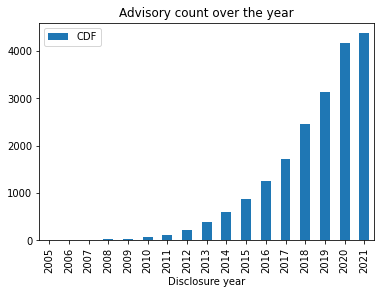

In [278]:
q= '''select year(a.disclose_date) as disclose_year, count(distinct a.id) as count
from advisory a
join package p on a.package_id = p.id
join fixing_releases fr on a.id = fr.advisory_id
where type != 'Malicious Package'
and version != 'manual checkup needed'
and ecosystem != 'cocoapods'
and repository_url != 'no repository listed'
group by year(a.disclose_date);'''
df = pd.DataFrame(sql.execute(q))
df['cdf']=df['count'].cumsum()
df = df.rename(columns = {'disclose_year':'Disclosure year', 'cdf':'CDF'})
fig = df.plot(x='Disclosure year',y='CDF',kind='bar', title = 'Advisory count over the year').get_figure()

In [279]:
fig.savefig('cdf_disclose.png')


In [280]:
df

,Disclosure year,count,CDF
0,2005,2,2
1,2006,4,6
2,2007,4,10
3,2008,10,20
4,2009,6,26
5,2010,45,71
6,2011,48,119
7,2012,105,224
8,2013,169,393
9,2014,203,596


In [281]:
(4377 - 872) / 4377

0.8007767877541695

In [282]:
(4377 - 872)

3505